In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
DATA = pd.read_csv("blood_transfusion.csv")

===TASK 1: Data Visualization===

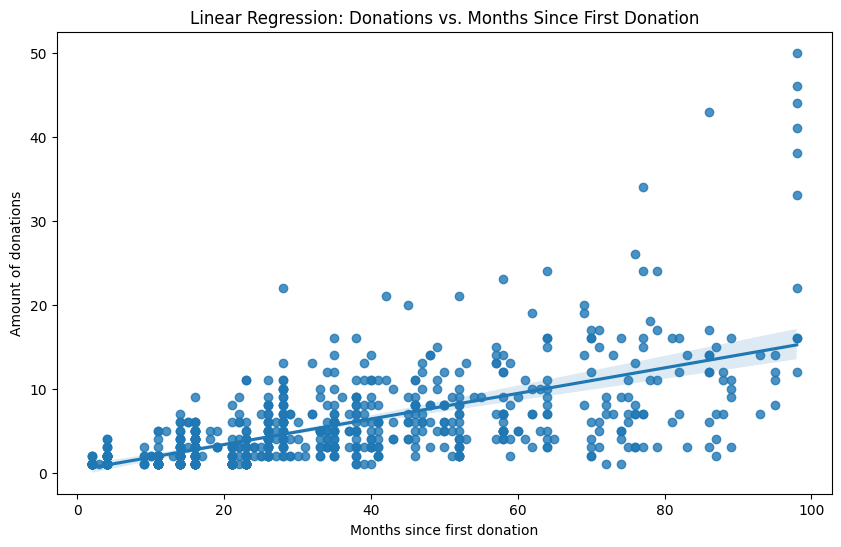

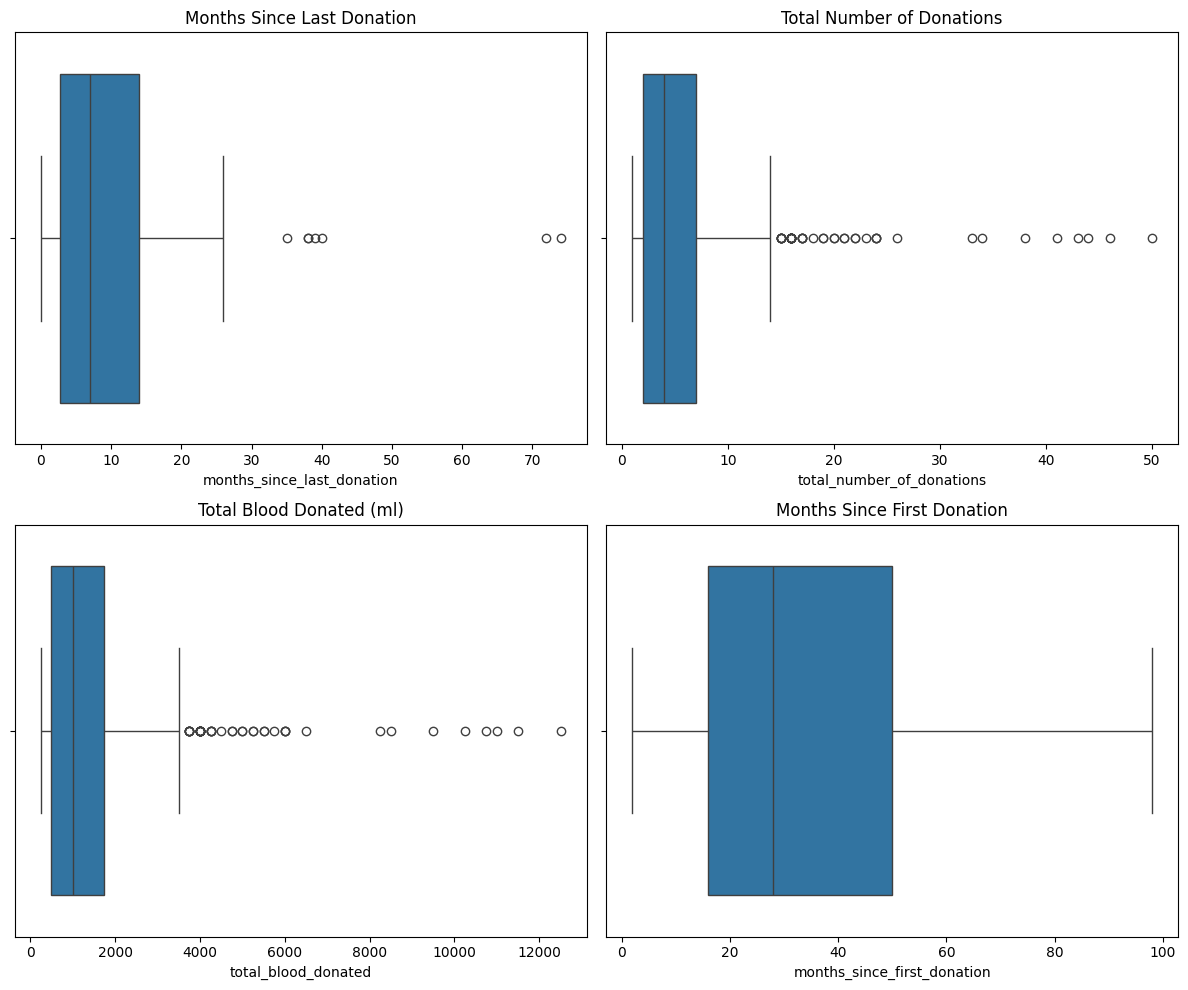

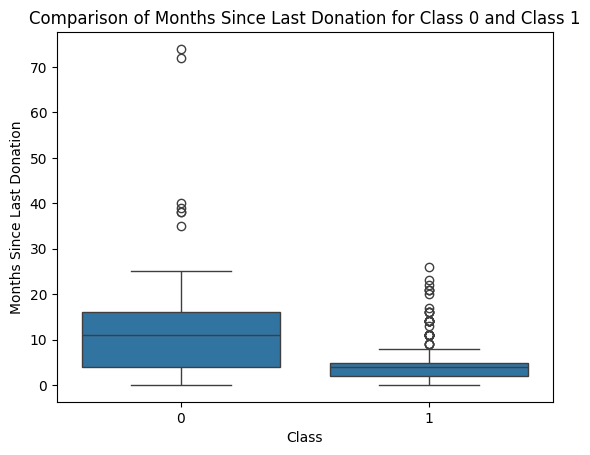

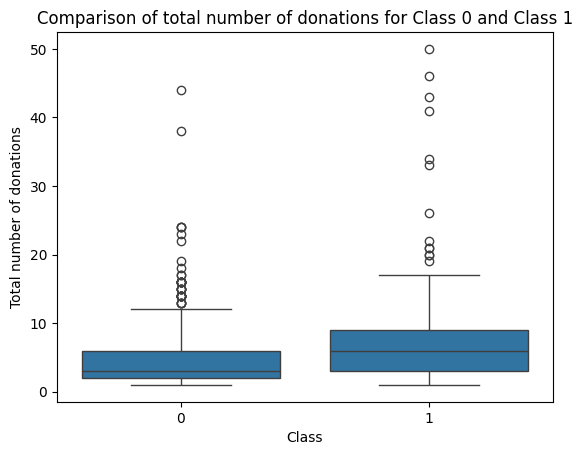

In [3]:
# Task 1.1 - Explore the dataset similarly to the first assignment, so you have a good understanding of 
# its content and features. Come up with an interesting one-minute story about the dataset.

months_since_first_donation = DATA["months_since_first_donation"]
total_number_of_donations = DATA["total_number_of_donations"]

plt.figure(figsize=(10,6))
sns.regplot(x=months_since_first_donation, y=total_number_of_donations, scatter=True, fit_reg=True)
plt.xlabel("Months since first donation")
plt.ylabel("Amount of donations")
plt.title("Linear Regression: Donations vs. Months Since First Donation")
plt.show()

# Create box plots for each feature separately
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(ax=axes[0, 0], data=DATA, x='months_since_last_donation')
axes[0, 0].set_title('Months Since Last Donation')

sns.boxplot(ax=axes[0, 1], data=DATA, x='total_number_of_donations')
axes[0, 1].set_title('Total Number of Donations')

sns.boxplot(ax=axes[1, 0], data=DATA, x='total_blood_donated')
axes[1, 0].set_title('Total Blood Donated (ml)')

sns.boxplot(ax=axes[1, 1], data=DATA, x='months_since_first_donation')
axes[1, 1].set_title('Months Since First Donation')

plt.tight_layout()
plt.show()

# Task 1.2 - Create a visualization, which shows the characteristics of tuples of class 1, compared to 
# tuples of class 0.
sns.boxplot(x=DATA["class"], y=DATA["months_since_last_donation"])

plt.xlabel("Class")
plt.ylabel("Months Since Last Donation")
plt.title("Comparison of Months Since Last Donation for Class 0 and Class 1")
plt.show()

sns.boxplot(x=DATA["class"], y=DATA["total_number_of_donations"])

plt.xlabel("Class")
plt.ylabel("Total number of donations")
plt.title("Comparison of total number of donations for Class 0 and Class 1")
plt.show()

===TASK 2: Preprocessing===

Think about the shape of the data that is used as input for classification algorithms. 
Use preprocessing techniques, which you deem necessary, to apply to this dataset.

In [12]:
DATA.info()
DATA.describe()
print(DATA.isnull().sum())

df = DATA
# Two features have more outliers, as seen in the skewed graph, for these we first conduct logarithmic normalization before min max normalization
skewed_features = ['total_number_of_donations','total_blood_donated']
for f in skewed_features:
    df[f] = df[f].astype(float)
    df[f] = np.log1p(DATA[f])

#We conduct min max normalization on all features to get them all to count evenly for the classification process.
minmax_features = ['total_number_of_donations','total_blood_donated','months_since_last_donation','months_since_first_donation']
for f in minmax_features:
    df[f] = (df[f] - df[f].min()) /(df[f].max() - df[f].min())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_since_last_donation   748 non-null    float64
 1   total_number_of_donations    748 non-null    float64
 2   total_blood_donated          748 non-null    float64
 3   months_since_first_donation  748 non-null    float64
 4   class                        748 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 29.3 KB
months_since_last_donation     0
total_number_of_donations      0
total_blood_donated            0
months_since_first_donation    0
class                          0
dtype: int64


===TASK 3: Creating a Train Set and a Test Set===

In [5]:
# Task 3.1 - Look for a function in the Sklearn documentation which can create train-test splits. Use 
# this function to create two train-test splits of different sizes. Throughout the entire PA keep 
# comparing the different splits and the impact they have on different tasks.

# Define the features and target variable
X = df[['months_since_last_donation', 'total_number_of_donations', 'total_blood_donated', 'months_since_first_donation']]
y = df['class']  # Class is the target variable as it says in the assignment

# First split: 80% train, 20% test
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 50% train, 50% test to show the difference with using less train data
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X, y, test_size=0.3, random_state=42)

print("80/20 split: ", X_train_80.shape, X_test_20.shape)
print("70/30 split: ", X_train_50.shape, X_test_50.shape)

80/20 split:  (598, 4) (150, 4)
70/30 split:  (523, 4) (225, 4)


===TASK 4: Classification Algorithm===

For the next questions, use the created training sets of both splits from question 3.1. 
Use the complementary test sets to predict the new cases. 

Predict a few cases that you pick at and compare the predicted labels with the actual 
labels. You will conduct a thorough evaluation in the task 5. Show that you have 
developed a feeling for the classification results.

In [20]:
# Task 4.1 - Manually implement a KNN classifier. You are not allowed to use any predefined functions 
# or libraries, except for auxiliary functionalities, such as the square root function of the Math 
# library.

#print(X_train_80.dtypes)
#print(X_test_80.dtypes)
#print(X_train_80.head())
#print(X_test_80.head())
#print(X_train_80.applymap(lambda x: isinstance(x, str)).any())  # Should return False
#print(X_test_80.applymap(lambda x: isinstance(x, str)).any())  

#We first define a function to get the euclidian distance between two points
def euclidean_distance(point1, point2):
    distance = 0.0
    for i in range(len(point1)):
        distance += (point1[i] - point2[i]) ** 2  
    return distance ** 0.5  

# This function creates a list of the distances between every point in the test data and a given point. It then returns the first k distances in the list.
def get_k_nearest_neighbors(X_train, y_train, test_point, k):
    distances = []
    for i in range(len(X_train)):
        distance = euclidean_distance(X_train.iloc[i], test_point)  # Calculate distance
        distances.append((distance, y_train.iloc[i]))  # Store distance and corresponding class label
    
    # Sort the distances list by the distance value
    distances.sort(key=lambda x: x[0])
    
    # Get the K nearest neighbors and their class label
    k_nearest_neighbors = distances[:k]
    return k_nearest_neighbors

def predict_class(k_nearest_neighbors):
    class_votes = {}

    # Go over the k nearest neighbors and count their class labels
    for neighbor in k_nearest_neighbors:
        # Find class label of the neighbor
        label = neighbor[1]  
        if label in class_votes:
            class_votes[label] += 1
        else:
            class_votes[label] = 1
    
    # Find the class label with the most votes
    majority_class = max(class_votes, key=class_votes.get)
    return majority_class

def knn_classifier(X_train, y_train, X_test, k):
    predictions = []
    
    for index in range(len(X_test)):
        test_point = X_test.iloc[index]  # Get the test point
        k_nearest_neighbors = get_k_nearest_neighbors(X_train, y_train, test_point, k)  # Get K nearest neighbors
        predicted_class = predict_class(k_nearest_neighbors)  # Predict the class
        predictions.append(predicted_class)  # Store the prediction
    
    return predictions

k = 3


actual_labels = y_test_20  # Actual labels for those cases
predicted_labels = knn_classifier(X_train_80, y_train_80, X_test_20, k)
accuracy = accuracy_score(y_test_20, predicted_labels)  # Assuming y_test_80 is the true labels
print("Accuracy for 80%:", accuracy)

actual_labels50 = y_test_50  # Actual labels for those cases
predicted_labels50 = knn_classifier(X_train_50, y_train_50, X_test_50, k)
accuracy = accuracy_score(y_test_50, predicted_labels50)  # Assuming y_test_80 is the true labels
print("Accuracy for 50%:", accuracy)

 
# Task 4.2 - Use Sklearn's Naive Bayes Classifier. Predict a few new cases and compare the predicted 
# labels with the actual labels. 

# First using the Naive Bayes Classifier on the 80/20 split
gaussian80_NB = GaussianNB()
gaussian80_NB.fit(X_train_80,y_train_80)

gnb80_predict_y = gaussian80_NB.predict(X_test_20)

gnb80_accuracy = accuracy_score(y_test_20,gnb80_predict_y)
print("On the 80/20 split the accuracy for GNB is:", gnb80_accuracy)

# Secondly using the Naive Bayes Classifier on the 50/50 split
gaussian50_NB= GaussianNB()
gaussian50_NB.fit(X_train_50,y_train_50)

gnb50_predict_y = gaussian50_NB.predict(X_test_50)

gnb50_accuracy = accuracy_score(y_test_50,gnb50_predict_y)
print("On the 50/50 split the accuracy for GNB is:", gnb50_accuracy)



 
# Task 4.3 - Use Sklearn's Support Vector Classifier. Predict a few new cases and compare the 
# predicted labels with the actual labels.

# First using SVC on the 80/20 split
sv80 = SVC()

sv80.fit(X_train_80,y_train_80)

sv80_predict_y = sv80.predict(X_test_20)

sv80_accuracy = accuracy_score(y_test_20,sv80_predict_y)

print("The accuracy of the SVC on the 80/20 split is:", sv80_accuracy)

# Secondly using SVC on the 50/50 split
sv50 = SVC()

sv50.fit(X_train_50,y_train_50)

sv50_predict_y = sv50.predict(X_test_50)

sv50_accuracy = accuracy_score(y_test_50,sv50_predict_y)

print("The accuracy of the SVC on the 50/50 split is:", sv50_accuracy)

 
# Task 4.4 - Use Sklearn's Multilayer Perceptron (Neural Network) Classifier. Predict a few new cases 
# and compare the predicted labels with the actual labels.

# Firstly perfrom MLP on the 80/20 split
mlp80 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=11)

mlp80.fit(X_train_80,y_train_80)

mlp80_pred_y = mlp80.predict(X_test_20)

mlp80_accuracy = accuracy_score(y_test_20,mlp80_pred_y)

print("The accuracy for MLP on the 80/20 split is:", mlp80_accuracy)

# Secondly perform MLP on the 50/50 split
mlp50 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=11)

mlp50.fit(X_train_50,y_train_50)

mlp50_pred_y = mlp50.predict(X_test_50)

mlp50_accuracy = accuracy_score(y_test_50,mlp50_pred_y)

print("The accuracy for MLP on the 50/50 split is:", mlp50_accuracy)



/var/folders/gc/9ml3w_r92xn0tsh3p0k69h8m0000gn/T/ipykernel_7055/2533519922.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distance += (point1[i] - point2[i]) ** 2


Accuracy for 80%: 0.6866666666666666


/var/folders/gc/9ml3w_r92xn0tsh3p0k69h8m0000gn/T/ipykernel_7055/2533519922.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distance += (point1[i] - point2[i]) ** 2


Accuracy for 50%: 0.7422222222222222
On the 80/20 split the accuracy for GNB is: 0.7466666666666667
On the 50/50 split the accuracy for GNB is: 0.7377777777777778
The accuracy of the SVC on the 80/20 split is: 0.7533333333333333
The accuracy of the SVC on the 50/50 split is: 0.7333333333333333
The accuracy for MLP on the 80/20 split is: 0.7733333333333333
The accuracy for MLP on the 50/50 split is: 0.7511111111111111


===TASK 5: Evaluation of Classification Methods===

For the next questions, use the already fitted/learned models from the previous task 
for the splits you have created in Task 3.

In [5]:
# Task 5.1 - Manually implement a confusion matrix to evaluate the results of the classification 
# models. You are not allowed to use any predefined functions or libraries.
 
# Task 5.2 - Use Sklearn's classification report function to evaluate the results of the classification 
# models.
 
# Task 5.3 - Use Sklearn's fbeta score function to evaluate the results of the classification models.

===TASK 6: Cross-Validation===

In [6]:
# Task 6.1 - Apply Sklearn's K-Fold cross-validation on both splits of one of the classification 
# algorithms to optimize at least one parameter of the algorithm you have chosen. Use scores 
# from task 5 when evaluating each fold. Afterwards, refit the classifier, this time with the best 
# parameter setting. Render plots showing the evaluation scores for each fold. Also render 
# plot(s) showing the difference between not using cross-validation and using cross-validation 
# for this algorithm with both splits.